In [1]:
import time
import glob
import os
import re
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'seaborn: {sns.__version__}')

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', str)

pandas: 2.1.1
numpy: 1.26.0
matplotlib: 3.8.0
seaborn: 0.13.0


# Load National School Data

We can get school establishment data from the [Department for Education (DfE) website](https://www.get-information-schools.service.gov.uk/Downloads). The dataset all active schools in the UK, and contains UPRN (Unique Property Reference Number) for identifying their accurate location. We can join it with the Ordnance Survey's Code-Point Open dataset to get the geographic coordinates of each school. We can then apply the same process as we did for the transport data to get the school coverage (and their performance) for each properties in the PPD dataset.

In [2]:
from modules.utils import load_data

def map_ofsted_rating(rating):
    if rating == 'Outstanding':
        return 6
    elif rating == 'Good':
        return 5
    elif rating == 'Requires improvement':
        return 4
    elif rating == 'Inadequate':
        return 3
    else:
        return None if pd.isnull(rating) else 1

def load_school_data():
    saved_name = 'national_school_edubasealldata20230402'

    columns = ['URN', 'EstablishmentName', 'TypeOfEstablishment (name)', 'EstablishmentTypeGroup (name)', 'EstablishmentStatus (name)', 'PhaseOfEducation (name)', 'Boarders (name)', 'NurseryProvision (name)', 'Gender (name)', 'ReligiousCharacter (name)', 'NumberOfPupils', 'Easting', 'Northing', 'UPRN', 'OfstedRating (name)']
    
    df = load_data(
        saved_name,
        lambda f: pd.read_csv(
            f, usecols=columns, encoding='ISO-8859-1', low_memory=False
        )
    )

    if df is None:
        raise Exception('School data not found')

    # Rename columns
    df.rename(columns={'EstablishmentName': 'NAME', 'TypeOfEstablishment (name)': 'TYPE', 'EstablishmentTypeGroup (name)': 'MINORGROUP', 'EstablishmentStatus (name)': 'STATUS', 'PhaseOfEducation (name)': 'PHASE', 'Boarders (name)': 'BOARDING', 'NurseryProvision (name)': 'NURSERY', 'Gender (name)': 'GENDER', 'ReligiousCharacter (name)': 'RELCHAR', 'NumberOfPupils': 'TOTALPUPILS', 'OfstedRating (name)': 'OFSTEDRATING'}, inplace=True)
    
    # Drop inactive or closing schools
    df = df[df['STATUS'] == 'Open']

    # Map OFSTED ratings to numeric values
    df['OFSTEDRATING'] = df['OFSTEDRATING'].apply(map_ofsted_rating)

    df = df.add_prefix('SCH_')
    df.set_index('SCH_URN', inplace=True)

    return df

df = load_school_data()

Loading saved data from ./data/saved/national_school_edubasealldata20230402.parquet...


In [3]:
df['SCH_OFSTEDRATING'].value_counts()

SCH_OFSTEDRATING
5.0    15425
6.0     3098
4.0     1796
1.0      165
3.0       92
Name: count, dtype: int64

Load Ordnance Survey's Open UPRN and enrich school's geographical location.

In [4]:
import modules.dataset_uprn as uprn

uprn_df = uprn.load_data()

Loading saved data from ./data/saved/osopenuprn_202301.parquet...


Enrich the school performance data with the school's geographical location.

In [5]:
import modules.utils as utils

# Slow running, 12 minutes for 5k records
def enrich_school_data(df, uprn_df):
    df = df.copy()

    # left join SCH and UPRN dataset
    df = pd.merge(df.reset_index(), uprn_df, how='left', left_on='SCH_UPRN', right_on='UPRN')

    # Drop records that have not been matched - they are not in London
    print('Matching rate:', utils.format_ratio(len(df[df['UPRN_LATITUDE'].notna()]), len(df.index)))
    df = df[df['UPRN_LATITUDE'].notna()]

    df.set_index('SCH_URN', inplace=True)

    return df

enriched_df = enrich_school_data(df, uprn_df)
enriched_df.info()

Matching rate: 96.3776%
<class 'pandas.core.frame.DataFrame'>
Index: 26047 entries, 100000 to 402467
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SCH_NAME          26047 non-null  object 
 1   SCH_TYPE          26047 non-null  object 
 2   SCH_MINORGROUP    26047 non-null  object 
 3   SCH_STATUS        26047 non-null  object 
 4   SCH_PHASE         26047 non-null  object 
 5   SCH_BOARDING      25167 non-null  object 
 6   SCH_NURSERY       26026 non-null  object 
 7   SCH_GENDER        25825 non-null  object 
 8   SCH_RELCHAR       20235 non-null  object 
 9   SCH_TOTALPUPILS   23433 non-null  float64
 10  SCH_Easting       25889 non-null  float64
 11  SCH_Northing      25889 non-null  float64
 12  SCH_OFSTEDRATING  20196 non-null  float64
 13  SCH_UPRN          26047 non-null  float64
 14  UPRN_LATITUDE     26047 non-null  float64
 15  UPRN_LONGITUDE    26047 non-null  float64
dtypes: float64(7), 

In [6]:
enriched_df['SCH_PHASE'].value_counts()

SCH_PHASE
Primary                    16523
Not applicable              5492
Secondary                   3114
Nursery                      371
16 plus                      290
All-through                  154
Middle deemed secondary       95
Middle deemed primary          8
Name: count, dtype: int64

In [7]:
from sklearn.neighbors import BallTree

def get_school_within_radius(df, central_point, radius, type=None, tree_setup=None):
    # If the tree is not already setup, create it
    if tree_setup is None:
        # Convert the entire search coordinates to radians
        if type == 'nursery':
            selected = df[df['SCH_PHASE'] == 'Nursery'][['SCH_LATITUDE', 'SCH_LONGITUDE']]
        elif type == 'primary':
            selected = df[(df['SCH_PHASE'] == 'Primary') | (df['SCH_PHASE'] == 'Middle deemed primary') | (df['SCH_PHASE'] == 'All-through')][['UPRN_LATITUDE', 'UPRN_LONGITUDE']]     
        elif type == 'secondary':
            selected = df[(df['SCH_PHASE'] == 'Secondary') | (df['SCH_PHASE'] == 'Middle deemed secondary') | (df['SCH_PHASE'] == 'All-through')][['UPRN_LATITUDE', 'UPRN_LONGITUDE']]  
        elif type == 'post16':
            selected = df[(df['SCH_PHASE'] == '16 plus') | (df['SCH_PHASE'] == 'All-through')][['UPRN_LATITUDE', 'UPRN_LONGITUDE']]    
        else:
            selected = df[['UPRN_LATITUDE', 'UPRN_LONGITUDE']]  

        rad_df = np.radians(selected)

        # Create a BallTree
        tree = BallTree(rad_df, metric='haversine')
    else:
        tree, rad_df = tree_setup

    # Define the search radius, with the Earth's radius in meters
    search_radius = radius / 6371e3

    # Calculate the count of nearby records in DataFrame y for each record in DataFrame x
    nearby_points = tree.query_radius(np.radians(pd.DataFrame(central_point)).values.reshape(1, -1), r=search_radius)

    # Return the nearby records
    return pd.DataFrame([df.loc[rad_df.iloc[indices].name] for indices in nearby_points[0]])

In [8]:
enriched_df[enriched_df['SCH_MINORGROUP'] == 'Universities'].head()

,SCH_NAME,SCH_TYPE,SCH_MINORGROUP,SCH_STATUS,SCH_PHASE,SCH_BOARDING,SCH_NURSERY,SCH_GENDER,SCH_RELCHAR,SCH_TOTALPUPILS,SCH_Easting,SCH_Northing,SCH_OFSTEDRATING,SCH_UPRN,UPRN_LATITUDE,UPRN_LONGITUDE
SCH_URN,,,,,,,,,,,,,,,,
130545,Leeds College of Music,Higher education institutions,Universities,Open,Not applicable,No boarders,Not applicable,Mixed,Does not apply,NaN,430866.0,433569.0,NaN,72195240.0,53.7974704,-1.5328738
130547,Leeds Arts University,Higher education institutions,Universities,Open,Not applicable,No boarders,Not applicable,Mixed,Does not apply,NaN,429635.0,434834.0,5.0,72563758.0,53.8089452,-1.5509546
130650,Plymouth College of Art,Higher education institutions,Universities,Open,Not applicable,No boarders,Not applicable,Mixed,Does not apply,NaN,248106.0,54797.0,5.0,100041165444.0,50.373396,-4.1374404
133250,Falmouth University,Higher education institutions,Universities,Open,Not applicable,No boarders,Not applicable,Mixed,None,NaN,180711.0,32196.0,NaN,100041022282.0,50.1579575,-5.0952696
133784,University of Birmingham,Higher education institutions,Universities,Open,Not applicable,No boarders,Not applicable,Mixed,None,NaN,404796.0,283448.0,NaN,10090430716.0,52.4532818,-1.9278934


In [9]:
# filtered_df = get_school_within_radius(df=enriched_df, central_point=(51.39767882718939, 0.00850426568138833), radius=1000)
# filtered_df = get_school_within_radius(df=enriched_df, central_point=(51.407734, -0.032874), radius=500)
filtered_df = get_school_within_radius(df=enriched_df, central_point=(51.39, -0.08), radius=804)
filtered_df

,SCH_NAME,SCH_TYPE,SCH_MINORGROUP,SCH_STATUS,SCH_PHASE,SCH_BOARDING,SCH_NURSERY,SCH_GENDER,SCH_RELCHAR,SCH_TOTALPUPILS,SCH_Easting,SCH_Northing,SCH_OFSTEDRATING,SCH_UPRN,UPRN_LATITUDE,UPRN_LONGITUDE
138502,Robert Fitzroy Academy,Academy sponsor led,Academies,Open,Primary,No boarders,Not applicable,Mixed,None,588.0,533607.0,167089.0,5.0,200001209533.0,51.3871257,-0.0812595
148043,Aya College (Educational Provision),Other independent school,Independent schools,Open,Not applicable,No boarders,No Nursery Classes,Mixed,None,2.0,532911.0,167630.0,4.0,100020645128.0,51.3921508,-0.0910536
148772,Beckmead College,Academy special converter,Academies,Open,Not applicable,No boarders,No Nursery Classes,Mixed,None,80.0,533612.0,168141.0,NaN,100023260554.0,51.3965783,-0.080792
142610,John Wood School & Nursery,Academy sponsor led,Academies,Open,Primary,No boarders,No Nursery Classes,Mixed,Does not apply,239.0,533675.0,166776.0,5.0,200001204586.0,51.385171,-0.0799616
138612,St Thomas Becket Catholic Primary School,Academy converter,Academies,Open,Primary,No boarders,No Nursery Classes,Mixed,Roman Catholic,409.0,534345.0,167335.0,5.0,200001205933.0,51.3891621,-0.0705667
146543,South Norwood Primary,Academy sponsor led,Academies,Open,Primary,None,Not applicable,Mixed,None,311.0,534121.0,168019.0,NaN,100023260055.0,51.3953618,-0.073526
143178,Woodside Primary School,Academy converter,Academies,Open,Primary,No boarders,Has Nursery Classes,Mixed,Does not apply,582.0,534078.0,166848.0,5.0,100022907705.0,51.385237,-0.0730314


Enrich the Price Paid Dataset with the nearby school information. We will use the same process as we did for the transport data.

In [10]:
from modules.utils import load_saved_data

ppd_df = load_saved_data('1_ppd_epc_data')

Loading saved data from ./data/saved/1_ppd_epc_data.parquet...


In [17]:
def enrich_with_school_data(ppd_df, sch_df):
    ppd_df = ppd_df[ppd_df['UPRN_LATITUDE'].notna()].reset_index()[['PPD_ID', 'UPRN_LATITUDE', 'UPRN_LONGITUDE']]

    rad_df = np.radians(sch_df[['UPRN_LATITUDE', 'UPRN_LONGITUDE']])
    tree = BallTree(rad_df, metric='haversine')

    type_map = {
        'SCH_ACAD': sch_df['SCH_MINORGROUP'] == 'Academies',
        'SCH_IND': sch_df['SCH_MINORGROUP'] == 'Independent schools',
        'SCH_NURSERY': (sch_df['SCH_PHASE'] == 'Nursery') | (sch_df['SCH_NURSERY'] == 'Has Nursery Classes'),
        'SCH_PRIMARY': sch_df['SCH_PHASE'].isin(['Primary', 'Middle deemed primary', 'All-through']),
        'SCH_SECONDARY': sch_df['SCH_PHASE'].isin(['Secondary', 'Middle deemed secondary', 'All-through']),
        'SCH_OUTSTANDING': sch_df['SCH_OFSTEDRATING'] >= 6,
        'SCH_GOOD': sch_df['SCH_OFSTEDRATING'] >= 5,
        'SCH_INADEQUATE': sch_df['SCH_OFSTEDRATING'] <= 3,
    }

    school_counts = []
    for _, row in ppd_df.iterrows():
        nearby_schools = get_school_within_radius(df=sch_df, central_point=(row['UPRN_LATITUDE'], row['UPRN_LONGITUDE']), radius=804, tree_setup=(tree, rad_df))

        if nearby_schools.empty:
            counts = {key: 0 for key in type_map.keys()}
            counts['SCH_ALL'] = 0
        else:
            counts = {key: nearby_schools[condition[nearby_schools.index]].shape[0] for key, condition in type_map.items()}
            counts['SCH_ALL'] = nearby_schools.shape[0]
        
        school_counts.append(counts)

    school_counts_df = pd.DataFrame(school_counts)
    ppd_df = pd.concat([ppd_df, school_counts_df], axis=1)

    ppd_df.set_index('PPD_ID', inplace=True)

    return ppd_df

enriched_ppd_df = enrich_with_school_data(ppd_df, enriched_df)

In [12]:
from modules.utils import save_data

# Save it for later
save_data(enriched_ppd_df.drop(columns=['UPRN_LATITUDE', 'UPRN_LONGITUDE']) , '4_ppd_school_data')

Saving data to ./data/saved/4_ppd_school_data.parquet...


In [18]:
enriched_ppd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 388451 entries, {DBA933F8-E298-669D-E053-6B04A8C0AD56} to {7C2D0701-0D22-4963-E053-6B04A8C07B97}
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   UPRN_LATITUDE    388451 non-null  float64
 1   UPRN_LONGITUDE   388451 non-null  float64
 2   SCH_ACAD         388451 non-null  int64  
 3   SCH_IND          388451 non-null  int64  
 4   SCH_NURSERY      388451 non-null  int64  
 5   SCH_PRIMARY      388451 non-null  int64  
 6   SCH_SECONDARY    388451 non-null  int64  
 7   SCH_OUTSTANDING  388451 non-null  int64  
 8   SCH_GOOD         388451 non-null  int64  
 9   SCH_INADEQUATE   388451 non-null  int64  
 10  SCH_ALL          388451 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 35.6+ MB


In [19]:
pd.options.display.float_format = '{:.2f}'.format
print(enriched_ppd_df['SCH_ALL'].describe(), end='\n\n')
print(enriched_ppd_df['SCH_GOOD'].describe(), end='\n\n')
print(enriched_ppd_df['SCH_OUTSTANDING'].describe(), end='\n\n')

count   388451.00
mean         5.93
std          4.03
min          0.00
25%          3.00
50%          5.00
75%          8.00
max         30.00
Name: SCH_ALL, dtype: float64

count   388451.00
mean         4.56
std          3.17
min          0.00
25%          2.00
50%          4.00
75%          6.00
max         23.00
Name: SCH_GOOD, dtype: float64

count   388451.00
mean         1.29
std          1.43
min          0.00
25%          0.00
50%          1.00
75%          2.00
max          9.00
Name: SCH_OUTSTANDING, dtype: float64



In [20]:
enriched_ppd_df[enriched_ppd_df['SCH_ALL'] == enriched_ppd_df['SCH_ALL'].max()]

,UPRN_LATITUDE,UPRN_LONGITUDE,SCH_ACAD,SCH_IND,SCH_NURSERY,SCH_PRIMARY,SCH_SECONDARY,SCH_OUTSTANDING,SCH_GOOD,SCH_INADEQUATE,SCH_ALL
PPD_ID,,,,,,,,,,,
{98C75472-AD74-72E9-E053-6B04A8C042F0},51.57,-0.08,3,19,20,7,3,2,14,10,30
{E2D14905-0042-4C2D-E053-6B04A8C0422B},51.57,-0.08,3,19,20,7,3,2,14,10,30


In [21]:
enriched_ppd_df

,UPRN_LATITUDE,UPRN_LONGITUDE,SCH_ACAD,SCH_IND,SCH_NURSERY,SCH_PRIMARY,SCH_SECONDARY,SCH_OUTSTANDING,SCH_GOOD,SCH_INADEQUATE,SCH_ALL
PPD_ID,,,,,,,,,,,
{DBA933F8-E298-669D-E053-6B04A8C0AD56},51.52,-0.02,3,0,4,5,1,0,5,0,5
{D4D42646-119A-27F6-E053-6C04A8C0A572},51.50,-0.14,2,3,5,4,2,1,5,0,9
{D22473F6-1ADB-7B40-E053-6C04A8C0A630},51.43,-0.35,0,0,1,2,0,1,2,0,2
{D22473F6-1AE0-7B40-E053-6C04A8C0A630},51.47,-0.26,1,0,1,4,1,4,5,0,5
{BEF7EBBE-8406-7A76-E053-6B04A8C092F7},51.57,-0.14,0,4,3,3,1,1,4,0,8
...,...,...,...,...,...,...,...,...,...,...,...
{D707E536-8793-0AD9-E053-6B04A8C067CC},51.60,-0.33,3,0,2,2,3,2,3,0,4
{D707E536-8796-0AD9-E053-6B04A8C067CC},51.60,0.04,0,0,2,2,1,1,3,0,3
{D707E536-8797-0AD9-E053-6B04A8C067CC},51.54,-0.23,4,0,4,3,2,2,7,0,7


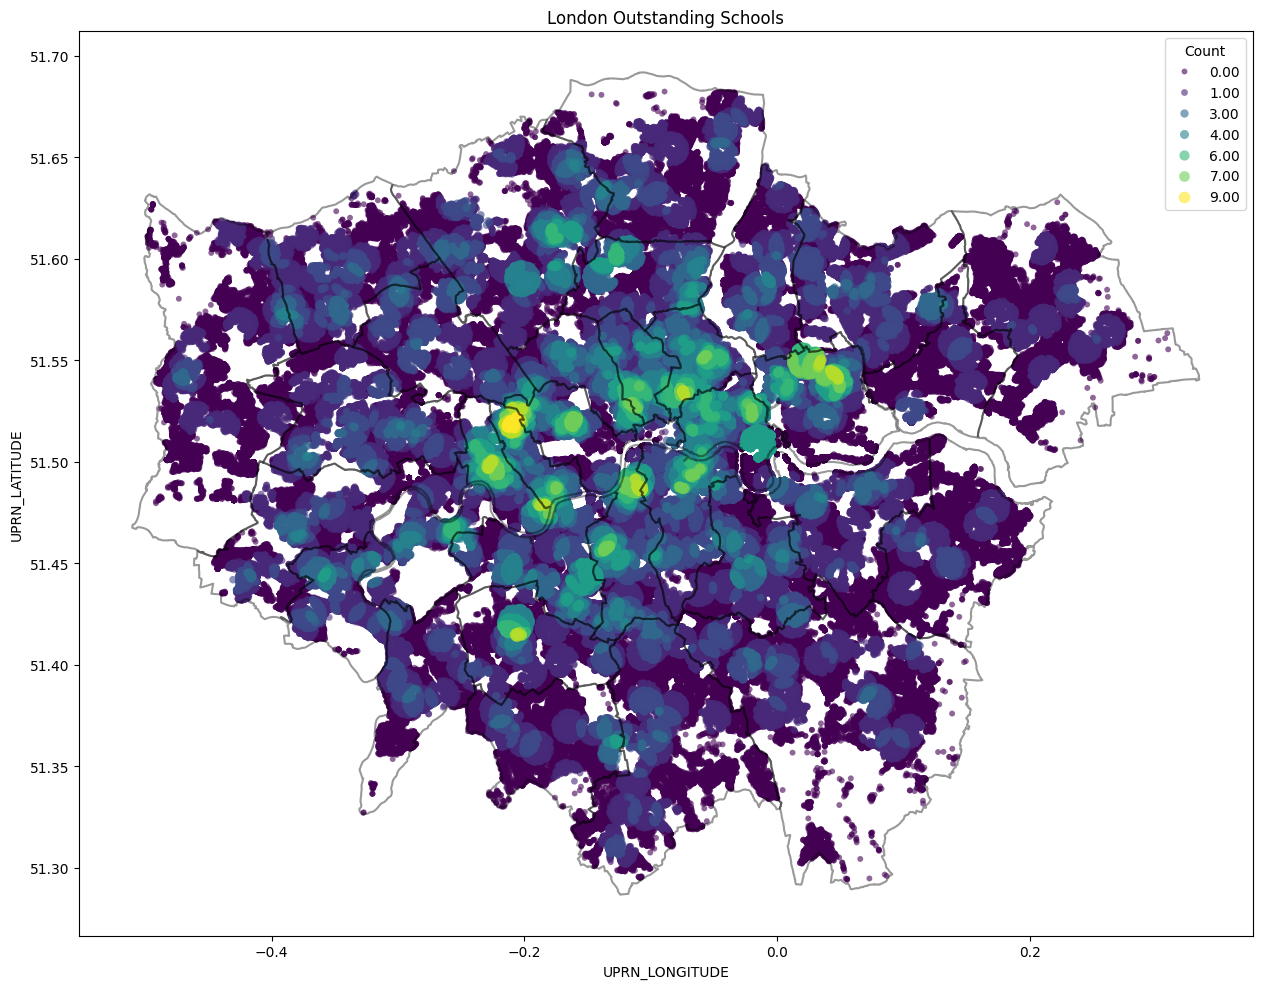

In [52]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

chart_df = enriched_ppd_df[['SCH_OUTSTANDING', 'SCH_ALL', 'UPRN_LONGITUDE', 'UPRN_LATITUDE']].copy()

# Load the shapefile, set the CRS, and convert the British National Grid to the Geodetic System (WGS84)
london = gpd.read_file('./data/map/London_Borough_Excluding_MHW.shp').set_crs('EPSG:27700').to_crs('EPSG:4326')
london['edgecolor'] = 'black'

fig, ax = plt.subplots(figsize=(15, 10))
scatter = sns.scatterplot(ax=ax, x='UPRN_LONGITUDE', y='UPRN_LATITUDE', data=chart_df.sort_values('SCH_OUTSTANDING'), 
                          size='SCH_OUTSTANDING', hue='SCH_OUTSTANDING', linewidth=0, alpha=0.6, palette='viridis')
london.boundary.plot(ax=ax, color=None, edgecolor=london['edgecolor'], alpha=0.4)

legend = ax.legend_
legend.set_title("Count")
for t in legend.texts:
    t.set_text(f'{round(float(t.get_text()), 2):,.2f}')

plt.title('London Outstanding Schools')
plt.tight_layout()
plt.show()

In [33]:
chart_df['SCH_OUTSTANDING_Log'].describe()

count   381218.00
mean        21.21
std         21.86
min          0.00
25%          0.00
50%         20.00
75%         33.33
max        100.00
Name: SCH_OUTSTANDING_Log, dtype: float64